In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]


In [ ]:
src = f"/home/andres/repos/rat-mapping-paper/reports/C_SMA_LAR/non_hierarchical_bayesian_model/inference.pkl"
with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
    ) = pickle.load(f)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
a = posterior_samples[site.a]
b = posterior_samples[site.b]
L = posterior_samples[site.L]
ell = posterior_samples[site.ell]
H = posterior_samples[site.H]

x = np.linspace(0, 500, 1000)

named_params = [site.a, site.b, site.L, site.ell, site.H]
params = [posterior_samples[param][:400, ...] for param in named_params]

for named_param, param in zip(named_params, params):
    
    print(named_param, param.shape)

a (400, 8, 70, 3, 6)
b (400, 8, 70, 3, 6)
L (400, 8, 70, 3, 6)
ℓ (400, 8, 70, 3, 6)
H (400, 8, 70, 3, 6)


In [4]:
output = F.solve_rectified_logistic(y=.95 * posterior_samples[site.H], a=posterior_samples[site.a], b=posterior_samples[site.b], L=0, ell=posterior_samples[site.ell], H=posterior_samples[site.H])
output_mean = output.mean(axis=0)


In [5]:
sizes = encoder_dict[model.features[2]].inverse_transform(sorted(df['compound_size'].unique()))
sizes

array(['B', 'S', 'S-B'], dtype=object)

<Axes: xlabel='pulse_amplitude', ylabel='Count'>

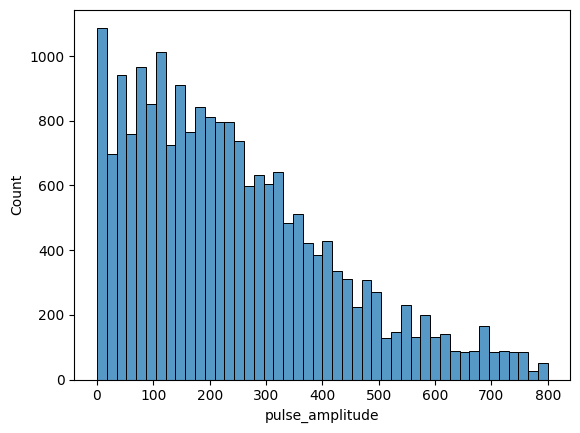

In [22]:
sns.histplot(df[model.intensity])

In [28]:
a_mean = a.mean(axis=0)
a_mean.shape

(8, 70, 3, 6)

In [45]:
np.nanmedian(a_mean[i, :, :2, :].reshape(-1,))

57.501875307594275

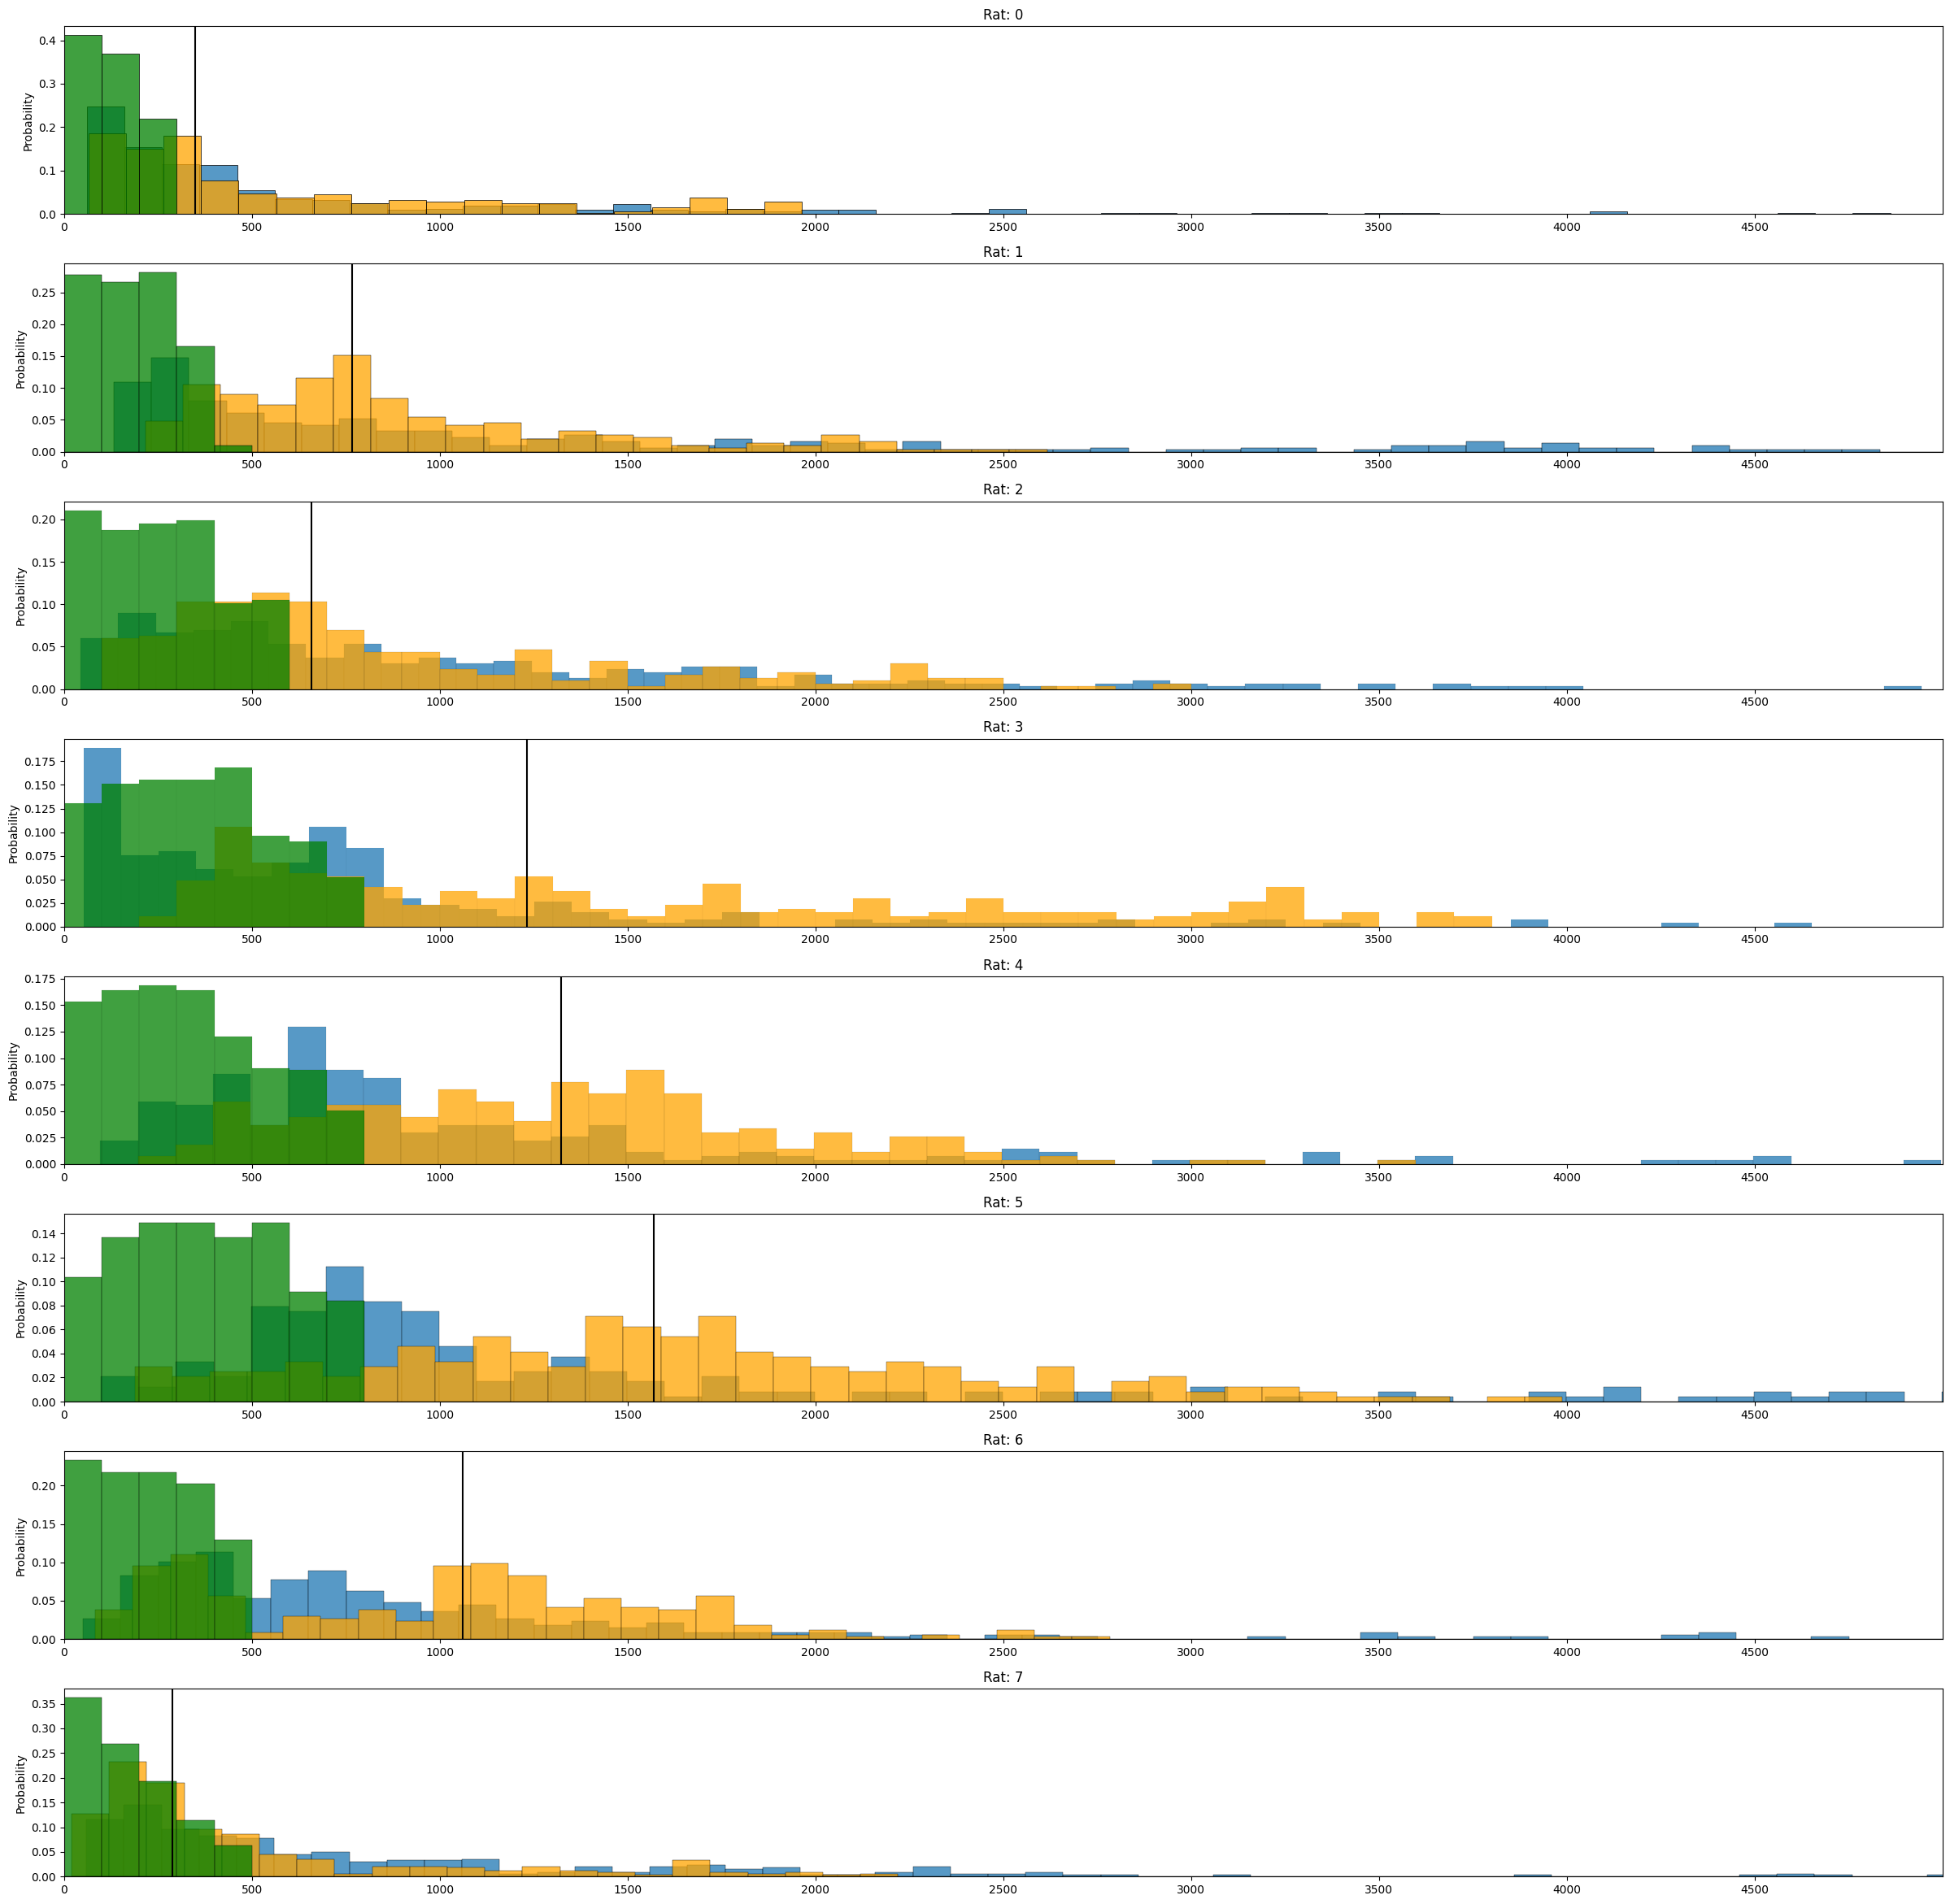

In [50]:
fig,ax = plt.subplots(8,1, figsize=(12, 8))

size_ind = 0
for i in range(8):
    sns.histplot(output_mean[i,:,:2,:].reshape(-1,), binwidth=100, ax=ax[i], stat="probability")
    sns.histplot(5 * a_mean[i, :, :2, :].reshape(-1,), ax=ax[i], binwidth=100, color="orange", stat="probability")
    ind = df["participant"] == i
    curr_df = df[ind].reset_index(drop=True).copy()
    intensities = curr_df[model.intensity].values
    sns.histplot(intensities.reshape(-1,), ax=ax[i], binwidth=100, color="g", stat="probability")
    ax[i].axvline(5 * np.nanmedian(a_mean[i, :, :2, :].reshape(-1,)), color="k")
    ax[i].set_title(f"Rat: {i}")
    ax[i].set_xlim(left=0, right=5000)
    ax[i].set_xticks(range(0, 5000, 500))
fig.tight_layout(rect=[0, 0.01, 2, 2.95])


In [58]:
np.nanmedian(a_mean[..., :2, :], axis=(1, 2, 3))

array([ 69.98619023, 153.4196472 , 131.73018533, 246.24686242,
       264.37446532, 313.88798055, 212.20331686,  57.50187531])

In [59]:
800 / 313.88798055

2.548679941800339

In [4]:
subjects = df['participant'].unique()
subjects = sorted(encoder_dict['participant'].inverse_transform(subjects))


In [5]:
norm_y = []
norm_x = []

for subject_ind, subject in enumerate(subjects):
    curr_params = [
        param[:, subject_ind, ...][..., None] for param in params
    ]
    constant = np.nanmedian(np.nanmean(curr_params[0], axis=0))

    x_temp = np.linspace(0., 5 * constant, 500)
    x_temp = x_temp[None, None, None, None, :]

    temp_thresh = F.rectified_logistic(
        x_temp,
        *curr_params
    )
    temp_thresh = temp_thresh - curr_params[2]
    norm_y.append(temp_thresh)
    norm_x.append(x_temp)

norm_y = np.array(norm_y)
norm_x = np.array(norm_x)

# print(norm_y.shape)
# print(norm_x.shape)


/tmp/ipykernel_196638/809937145.py:8: RuntimeWarning: Mean of empty slice
  constant = np.nanmedian(np.nanmean(curr_params[0], axis=0))
/tmp/ipykernel_196638/809937145.py:8: RuntimeWarning: Mean of empty slice
  constant = np.nanmedian(np.nanmean(curr_params[0], axis=0))


In [6]:
norm_y.shape

(8, 400, 70, 3, 6, 500)

In [7]:
compound_position = encoder_dict[model.features[1]].inverse_transform(sorted(df['compound_position'].unique()))
mono = [c for c in compound_position if c.split("-")[0] == "" or c.split("-")[1] == ""]
np.array(mono)

array(['-C5L', '-C5LL', '-C5LM', '-C5LM1', '-C5LM2', '-C5M', '-C6L',
       '-C6LL', '-C6LM', '-C6LM1', '-C6LM2', '-C6M', '-C6R', '-C6RM',
       '-C6RR', '-C7LM', '-C7M', '-C7R', '-C7RM', '-C7RR'], dtype='<U6')

In [8]:
laterality = ['LL','L', 'LM','LM1', 'LM2', 'M']
segments = ["-C5", "-C6", "-C7"]


In [9]:
arr = []
mask_biceps = [] 

# for subject in subjects:
#     for size in sizes:  
for segment in segments:
    for lat in laterality:
        cpos = f"{segment}{lat}"
        if cpos in mono:
            arr.append(norm_y[:,:,mono.index(cpos),...])

        else:
            arr.append(np.full(norm_y[:, :, 0, ...].shape, np.nan))

arr = np.array(arr)
arr = arr.reshape(len(segments), len(laterality), *arr.shape[1:])
arr.shape




(3, 6, 8, 400, 3, 6, 500)

In [10]:
arr = arr.swapaxes(0,3)
print(arr.shape)
arr = arr.swapaxes(1,2) #400, subjects, laterality, segments, sizes, muscles, 500
print(arr.shape)


(400, 6, 8, 3, 3, 6, 500)
(400, 8, 6, 3, 3, 6, 500)


In [11]:
sizes = encoder_dict[model.features[2]].inverse_transform(sorted(df['compound_size'].unique()))


In [14]:
arr[...,0,:,:].shape

(400, 8, 6, 3, 6, 500)

In [13]:
arr = ma.masked_invalid(arr)
arr.shape


(400, 8, 6, 3, 3, 6, 500)

In [15]:
def get_entropy(size_ind):
    y = arr[...,size_ind,:,:]
    x = norm_x

    y_max = ma.max(y, axis=(2,3, -1), keepdims=True) 

    y = ma.where(y, y / y_max, 0.)

    p = ma.sum(y, axis=-2, keepdims=True)
    p = ma.where(y, y / p, 0.)

    plogp = ma.where(p, p * ma.log(p), 0.)

    entropy = ma.where(
        ma.any(p, axis=-2, keepdims=True),
        (
            1
            + (ma.sum(plogp, axis=-2, keepdims=True) / np.log(plogp.shape[-2]))
        ),
        0.
    )
    entropy = entropy[..., 0, :]
    entropy.shape

    return entropy, x

In [16]:
func_entrop_big, x_val_big = get_entropy(0)
func_entrop_small, x_val_small = get_entropy(1)


In [34]:
func_entrop_big.shape

(400, 8, 6, 3, 500)

In [19]:
area_list = []
for subject_ind, subject in enumerate(subjects):

    for cpos_ind in range(len(func_entrop_big[0,0,:,0,0])):
        cpos = laterality[cpos_ind]
        x_temp = x_val_big[subject_ind, 0,0, ...]
        
        sample_integrals = func_entrop_big[:, subject_ind, cpos_ind, ...]

        # sample_integrals_mean = ma.mean(sample_integrals, axis=(0,-2))
        
        area = np.trapz(sample_integrals, x_temp)
        area_list.append(area)

# filt_positions = list(set((a[1] for a in area_list)))

area_list_big = np.array(area_list)

area_list_big = area_list_big.reshape(len(subjects), len(func_entrop_big[0,0,:,0,0]), *area_list_big.shape[1:])
area_list_big.shape

area_list_big = ma.masked_values(area_list_big, 0)
area_list_big_mean = ma.mean(area_list_big, axis=(-1, -2))



In [32]:
area_list_big_mean.shape

(8, 6)

In [1]:
area_list = []
for subject_ind, subject in enumerate(subjects):

    for cpos_ind in range(len(func_entrop_small[0,0,:,0,0])):
        cpos = laterality[cpos_ind]
        x_temp = x_val_small[subject_ind, 0,0, ...]
        
        sample_integrals = func_entrop_small[:, subject_ind, cpos_ind, ...]

        # sample_integrals_mean = ma.mean(sample_integrals, axis=(0,-2))
        
        area = np.trapz(sample_integrals, x_temp)
        area_list.append(area)

# filt_positions = list(set((a[1] for a in area_list)))

area_list_small = np.array(area_list)

area_list_small = area_list_small.reshape(len(subjects), len(func_entrop_small[0,0,:,0,0]), *area_list_small.shape[1:])
area_list_small.shape

area_list_small = ma.masked_values(area_list_small, 0)
area_list_small_mean = ma.mean(area_list_small, axis=(-1, -2))

NameError: name 'subjects' is not defined

In [22]:
area_list_small.shape

(8, 6, 400, 3)

In [25]:
area_list_small_mean.shape

(8, 6)

In [26]:
src = f"/home/andres/repos/rat-mapping-paper/notebooks/C_SMA_LAR/selectivity_means.pkl"

with open(src, "wb") as f:
    pickle.dump([area_list_small_mean, area_list_big_mean], f)

In [33]:
area_list_big_mean.shape

(8, 6)

In [21]:
area_list = ma.masked_values(area_list, 0)
area_list_mean = ma.mean(area_list, axis=(-1, -2))
t = area_list_mean[:, :, None] - area_list_mean[:, None, :]
ttest = stats.ttest_1samp(t, popmean=0, axis=0)
pvalue = ttest.pvalue

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [37]:
t = np.array([1, 2, 3])
t

array([1, 2, 3])

In [38]:
t[:, None] - t[None, :]

array([[ 0, -1, -2],
       [ 1,  0, -1],
       [ 2,  1,  0]])

In [40]:
t =area_list_big_mean[:, :, None] - area_list_big_mean[:, None, :]
t.shape

(8, 6, 6)

In [41]:
test = stats.ttest_1samp(t, popmean=0, axis=0)
p = test.pvalue
p.shape


(6, 6)

<Axes: >

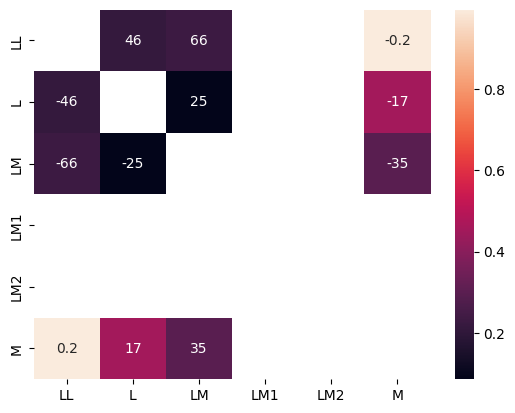

In [46]:
sns.heatmap(p, annot=t.mean(axis=0), xticklabels=laterality, yticklabels=laterality)

In [35]:
def selectivity(size_ind):
    sizes = encoder_dict[model.features[2]].inverse_transform(sorted(df['compound_size'].unique()))
        
    if size_ind == 1:
        ind = [0,1,3,4,5]
    else:
        ind = [0,1,2,5]
    
    ### GET ENTROPY
    f_entropy, f_x = get_entropy(size_ind)
    
    area_list = []
    for subject_ind, subject in enumerate(subjects):
        for cpos_ind in range(len(f_entropy[0,0,:,0,0])):
            
            x_temp = f_x[subject_ind, 0,0, ...]
            sample_integrals = f_entropy[:, subject_ind, cpos_ind, ...]
            area = np.trapz(sample_integrals, x_temp)
            area_list.append(area)

    area_list = np.array(area_list)
    area_list = area_list.reshape(len(subjects), len(f_entropy[0,0,:,0,0]), *area_list.shape[1:])
    area_list = ma.masked_values(area_list, 0)
    area_list_mean = ma.mean(area_list, axis=(-1, -2))
    t = area_list_mean[:, :, None] - area_list_mean[:, None, :]
    ttest = stats.ttest_1samp(t, popmean=0, axis=0)
        
    ### GET P VALUES
    p = ttest.pvalue
    
    ### GET MEAN TO PLOT
    p_mean = t.mean(axis=0)

    ### MASK NANs
    p_mean = p_mean[~p_mean.mask]
    p_mean = p_mean.reshape(len(ind),len(ind))

    ### GET VALUES WE WANT TO PLOT
    p_ = p[:,ind][ind, :]

    #FOR ANNOTATION
    data = []
    for ind_i, i in enumerate(p_):
        for ind_j, j in enumerate(i):
            data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
            # 
    data = np.array(data).reshape(len(ind),len(ind))

    #MASK LOWER TRIANGLE
    mask2= np.array(p_)
    mask2 = np.tril(np.ones_like(mask2), k=-1).astype(bool)

    #CORRECT LABELS
    labels = np.array(laterality)
    labels = labels.astype('U20')

    # if contact_ind == 0:
    #     labels[ind] = labels[ind]
    # else:
    #     labels[ind] = np.char.add(labels[ind],"-M")

    #PLOT
    ax=sns.heatmap(p_mean, xticklabels=labels[ind], yticklabels=labels[ind],annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


    ##ADD HATCH FOR SIGNIFICANCE
    handles = []
    hatch_mask = p_ > 0.1

    for i in range (p_.shape[0]):
        for j in range(p_.shape[1]):
            if hatch_mask[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='', label="Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='////', label="Not Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                        hatch='', label="Row Element Lower AUC"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                        hatch='', label="Row Element Higher AUC"))
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
            handlelength=2, handleheight=2, frameon=False)
    ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

    ax.yaxis.tick_right()
    ax.title.set_text(f"Monopolar - Size: {sizes[size_ind]}")
    
    return area_list_mean

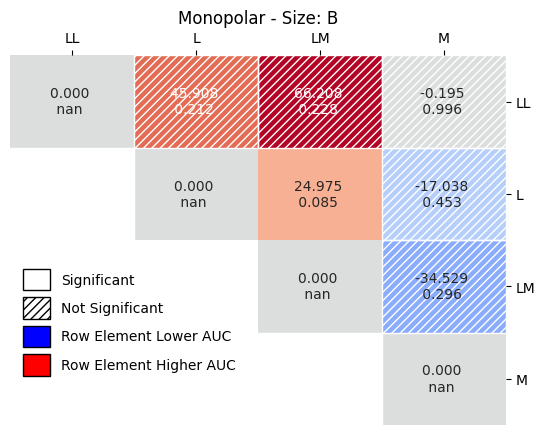

In [36]:
big = selectivity(0)

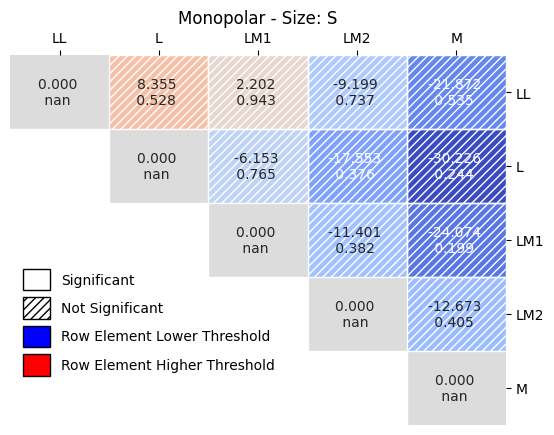

In [46]:
small = selectivity(1)

In [48]:
big.shape
small.shape

(8, 6)

In [22]:
big


NameError: name 'big' is not defined

In [50]:
big_edit = np.insert(big, 3, big[:, 2], axis = 1)
big_edit = np.delete(big_edit, [4,5], axis = 1)
small_edit = np.delete(small, 2, axis = 1)

In [53]:
small_edit.shape

(8, 5)

In [54]:
t = big_edit[:, :, None] - small_edit[:, None, :]
ttest = stats.ttest_1samp(t, popmean=0, axis=0)
pvalue = ttest.pvalue

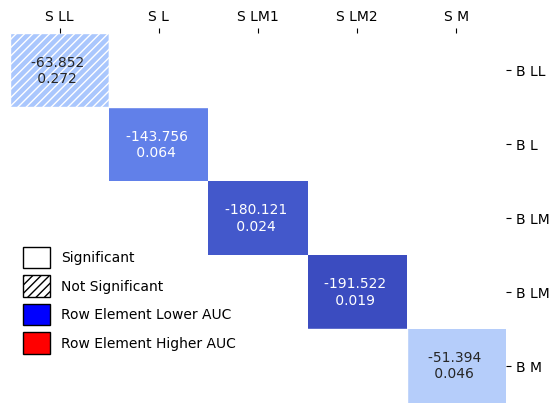

In [69]:
t = big_edit[:, :, None] - small_edit[:, None, :]
ttest = stats.ttest_1samp(t, popmean=0, axis=0)
pvalue = ttest.pvalue

### GET P VALUES
p = ttest.pvalue

### GET MEAN TO PLOT
p_mean = t.mean(axis=0)

### GET VALUES WE WANT TO PLOT
p_ = p

#FOR ANNOTATION
data = []
for ind_i, i in enumerate(p_):
    for ind_j, j in enumerate(i):
        data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
        # 
data = np.array(data).reshape(5,5)

#MASK LOWER TRIANGLE
mask2= np.array(p_)
mask2 = np.tril(np.ones_like(mask2), k=-1).astype(bool) + np.triu(np.ones_like(mask2), k=+1).astype(bool)

#CORRECT LABELS
y_labs = ['B LL', 'B L', 'B LM', 'B LM', 'B M']
x_labs = ['S LL', 'S L', 'S LM1', 'S LM2', 'S M']

# if contact_ind == 0:
#     labels[ind] = labels[ind]
# else:
#     labels[ind] = np.char.add(labels[ind],"-M")

#PLOT
ax=sns.heatmap(p_mean, xticklabels=x_labs, yticklabels=y_labs,annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


##ADD HATCH FOR SIGNIFICANCE
handles = []
hatch_mask = p_ > 0.1

for i in range (p_.shape[0]):
    for j in range(p_.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower AUC"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher AUC"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
        handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
